In [28]:
%load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook

from dataset import MNISTDataset
from models import CNN, AGCNN

In [116]:
def imshow(img, title=None):
    plt.imshow(img/(np.max(img)-np.min(img)))
    if title is not None:
        plt.title(title)
    plt.show()

In [144]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [117]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [118]:
data_dir = 'data/'
validation_split = 0.2
batch_size = 64
num_workers = 3
image_size = (64, 64)
num_classes = 10
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [119]:
train_set = MNISTDataset(os.path.join(data_dir, 'local_train_small.npz'), transform=transform)
val_set = MNISTDataset(os.path.join(data_dir, 'local_val_small.npz'), transform=transform)

In [130]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)

In [171]:
dropout = 0.2

model = CNN(input_shape=(1, *image_size), dropout=dropout, num_classes=num_classes)
model = model.to(device)

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.0)

num_epochs = 50
train_steps_per_epoch = int((len(train_set)+1)/batch_size)
val_steps_per_epoch = int((len(val_set)+1)/batch_size)
models_dir = 'models/'
model_name = 'local-CNN-small-adam'

In [134]:
writer = SummaryWriter(comment=model_name)

best_val_loss = float('inf')
print('Started Training')
for epoch in range(num_epochs):
    
    model.train(True)
    train_loss = 0.0
    for i, data in tqdm_notebook(enumerate(train_loader, 0),
                                 total=train_steps_per_epoch,
                                 desc='Epoch {}: '.format(epoch)):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        p = model(x)
        loss = criterion(p, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i >= train_steps_per_epoch:
            break
    writer.add_scalar('train_loss', train_loss / (len(train_set)/batch_size), epoch)
    
    model.eval()
    val_loss = 0.0
    y_true = None
    y_pred = None
    for i, data in enumerate(val_loader, 0):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        p = model(x)
        loss = criterion(p, y.float())
        val_loss += loss.item()
        if y_true is None:
            y_true = y
        else:
            y_true = torch.cat([y_true, y], dim=0)
            
        if y_pred is None:
            y_pred = y.byte()
        else:
            y_pred = torch.cat([y_pred, (torch.sigmoid(p).data > 0.5)], dim=0)

        if i >= val_steps_per_epoch:
            break
            
    y_true = torch.transpose(y_true, 0, 1).cpu().numpy()
    y_pred = torch.transpose(y_pred, 0, 1).cpu().numpy()

    f1score = []

    for i in range(num_classes):
        f1score.append(f1_score(y_true[i], y_pred[i]))

    avg_f1score = np.average(f1score)
    
    writer.add_scalar('validation_loss', val_loss / (len(val_set)/batch_size), epoch)
    writer.add_scalar('average f1-score on val. set', avg_f1score, epoch)
    
    print('train_loss: %.5f, validation_loss: %.5f, validation_f1-score: %.3f' % 
          (train_loss / (len(train_set)/batch_size), val_loss / (len(val_set)/batch_size), avg_f1score))
    
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), os.path.join(models_dir, model_name))
        best_val_loss = val_loss
        print('Model Saved!')
        
    train_loss = 0.0
    val_loss = 0.0
            
print('Finished Training')

Started Training


train_loss: 0.39515, validation_loss: 0.07713, validation_f1-score: 0.860
Model Saved!


train_loss: 0.09594, validation_loss: 0.05643, validation_f1-score: 0.903
Model Saved!


train_loss: 0.06936, validation_loss: 0.04838, validation_f1-score: 0.917
Model Saved!


train_loss: 0.05314, validation_loss: 0.04060, validation_f1-score: 0.931
Model Saved!


train_loss: 0.04444, validation_loss: 0.03890, validation_f1-score: 0.940
Model Saved!


train_loss: 0.03438, validation_loss: 0.04220, validation_f1-score: 0.936


train_loss: 0.03089, validation_loss: 0.03176, validation_f1-score: 0.952
Model Saved!


train_loss: 0.02918, validation_loss: 0.03721, validation_f1-score: 0.941


train_loss: 0.02228, validation_loss: 0.03118, validation_f1-score: 0.951
Model Saved!


train_loss: 0.02122, validation_loss: 0.03319, validation_f1-score: 0.949


train_loss: 0.02202, validation_loss: 0.03207, validation_f1-score: 0.954


train_loss: 0.02033, validation_loss: 0.03450, validation_f1-score: 0.952


train_loss: 0.01715, validation_loss: 0.03399, validation_f1-score: 0.951


train_loss: 0.01526, validation_loss: 0.03572, validation_f1-score: 0.950


train_loss: 0.01384, validation_loss: 0.03309, validation_f1-score: 0.958


train_loss: 0.01752, validation_loss: 0.03450, validation_f1-score: 0.960


train_loss: 0.01452, validation_loss: 0.03192, validation_f1-score: 0.956


train_loss: 0.01396, validation_loss: 0.03770, validation_f1-score: 0.950


train_loss: 0.01189, validation_loss: 0.03913, validation_f1-score: 0.954


train_loss: 0.00971, validation_loss: 0.04601, validation_f1-score: 0.953


train_loss: 0.01351, validation_loss: 0.03998, validation_f1-score: 0.953


train_loss: 0.01307, validation_loss: 0.04027, validation_f1-score: 0.961


train_loss: 0.01319, validation_loss: 0.03843, validation_f1-score: 0.954


train_loss: 0.01385, validation_loss: 0.05013, validation_f1-score: 0.949


train_loss: 0.01356, validation_loss: 0.04341, validation_f1-score: 0.956


train_loss: 0.00912, validation_loss: 0.04320, validation_f1-score: 0.955


train_loss: 0.01649, validation_loss: 0.05961, validation_f1-score: 0.951


train_loss: 0.01098, validation_loss: 0.04897, validation_f1-score: 0.958


train_loss: 0.01083, validation_loss: 0.05211, validation_f1-score: 0.958


train_loss: 0.00820, validation_loss: 0.05775, validation_f1-score: 0.946


train_loss: 0.00923, validation_loss: 0.04880, validation_f1-score: 0.954


train_loss: 0.01026, validation_loss: 0.05236, validation_f1-score: 0.951


train_loss: 0.00990, validation_loss: 0.05423, validation_f1-score: 0.949


train_loss: 0.01122, validation_loss: 0.05020, validation_f1-score: 0.955


train_loss: 0.00828, validation_loss: 0.04944, validation_f1-score: 0.954


train_loss: 0.00732, validation_loss: 0.05877, validation_f1-score: 0.951


train_loss: 0.01140, validation_loss: 0.05891, validation_f1-score: 0.951


train_loss: 0.00925, validation_loss: 0.05180, validation_f1-score: 0.956


train_loss: 0.00931, validation_loss: 0.06059, validation_f1-score: 0.957


train_loss: 0.01142, validation_loss: 0.05723, validation_f1-score: 0.955


train_loss: 0.00725, validation_loss: 0.05965, validation_f1-score: 0.954


train_loss: 0.00671, validation_loss: 0.06183, validation_f1-score: 0.958


train_loss: 0.00959, validation_loss: 0.06598, validation_f1-score: 0.956


train_loss: 0.01052, validation_loss: 0.05778, validation_f1-score: 0.958


train_loss: 0.00787, validation_loss: 0.07533, validation_f1-score: 0.954


train_loss: 0.00676, validation_loss: 0.06243, validation_f1-score: 0.952


train_loss: 0.00902, validation_loss: 0.06472, validation_f1-score: 0.953


train_loss: 0.00918, validation_loss: 0.07183, validation_f1-score: 0.952


train_loss: 0.01234, validation_loss: 0.06150, validation_f1-score: 0.954


train_loss: 0.00615, validation_loss: 0.05853, validation_f1-score: 0.957
Finished Training


In [129]:
torch.save(model.state_dict(), os.path.join(models_dir, 'local_cnn_best'))

In [177]:
model.load_state_dict(torch.load(os.path.join(models_dir,'ag_cnn_best')))

In [168]:
test_set = MNISTDataset(os.path.join(data_dir, 'test.npz'), transform=transform)

In [169]:
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

In [180]:
y_true = []
y_pred = []
y_pred_global = []
y_pred_local = []

model.eval()
with torch.no_grad():
    for data in tqdm_notebook(test_loader,
                              total=len(test_loader),
                              desc='Evaluating: '):
        images, labels = data.values()
        images = images.cuda(device)
        global_outputs = model.global_branch(images)
        y_pred_global += list((torch.sigmoid(global_outputs).data > 0.5 ).cpu().numpy())
        local_images = model._get_local_img(images)
        local_outputs = model.local_branch(local_images)
        outputs = model(images)
        y_true += list(labels.numpy())
        y_pred += list((torch.sigmoid(outputs).data > 0.5 ).cpu().numpy())
        y_pred_local += list((torch.sigmoid(local_outputs).data > 0.5 ).cpu().numpy())
        
y_true = np.asarray(y_true).T
y_pred = np.asarray(y_pred).T
y_pred_global = np.asarray(y_pred_global).T
y_pred_local = np.asarray(y_pred_local).T

f1score = []
f1score_global = []
f1score_local = []

for i in range(num_classes):
    f1score.append(f1_score(y_true[i], y_pred[i]))
    f1score_global.append(f1_score(y_true[i], y_pred_global[i]))
    f1score_local.append(f1_score(y_true[i], y_pred_local[i]))
    
avg_f1score = np.average(f1score)
avg_f1score_global = np.average(f1score_global)
avg_f1score_local = np.average(f1score_local)
    
print(f1score_local)
print('Average f1-score for global branch = {}'.format(avg_f1score_global))

print(f1score_local)
print('Average f1-score for local branch = {}'.format(avg_f1score_local))
    
print(f1score)
print('Average f1-score = {}'.format(avg_f1score))

[0.9768637532133676, 0.9263992948435434, 0.9496332518337408, 0.9186106791083463, 0.9455497382198953, 0.9221902017291067, 0.9573560767590619, 0.9453658536585366, 0.9161772557394554, 0.9197439684884294]
Average f1-score for global branch = 0.7320489675472558
[0.9768637532133676, 0.9263992948435434, 0.9496332518337408, 0.9186106791083463, 0.9455497382198953, 0.9221902017291067, 0.9573560767590619, 0.9453658536585366, 0.9161772557394554, 0.9197439684884294]
Average f1-score for local branch = 0.9377890073593484
[0.978205778003041, 0.9644128113879004, 0.9571567672833496, 0.9540171803941385, 0.9492360768851651, 0.9480225988700565, 0.9661733615221987, 0.9558466763706939, 0.946865037194474, 0.9473145780051151]
Average f1-score = 0.9567250865916131


In [41]:
idx = np.random.randint(0, len(val_set), size=1)

[6] [6]


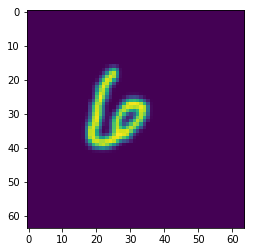

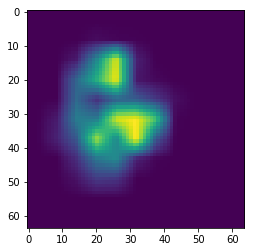

In [70]:
with torch.no_grad():
    x, y = val_set[idx[0]].values()
    x = x[None, :, :].to(device)
    f = model.visualise_features(x, True)
    output = model(x)
    p = np.where(torch.sigmoid(output).data.cpu().numpy() > 0.5)[1]
    y = np.where(y == 1)[0]
    im = x[0][0].cpu().numpy()
    im_f = f

print(y, p)
imshow(im)
imshow(im_f)

In [151]:
train_set = MNISTDataset(os.path.join(data_dir, 'train_small.npz'), transform=transform)
val_set = MNISTDataset(os.path.join(data_dir, 'val_small.npz'), transform=transform)

In [165]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)

In [176]:
dropout = 0.2

model = AGCNN(input_shape=(1, *image_size), dropout=dropout, num_classes=num_classes)
# model.global_branch.load_state_dict(torch.load(os.path.join(models_dir, 'cnn_best')))
# model.local_branch.load_state_dict(torch.load(os.path.join(models_dir, 'local_cnn_best')))
model = model.to(device)

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.001, lr=0.0001)

num_epochs = 50
train_steps_per_epoch = int((len(train_set)+1)/batch_size)
val_steps_per_epoch = int((len(val_set)+1)/batch_size)
models_dir = 'models/'
model_name = 'AG-CNN-small-adam'

model.set_train_branch('fusion')

In [166]:
writer = SummaryWriter(comment=model_name)

best_val_loss = float('inf')
print('Started Training')
for epoch in range(num_epochs):
    
    model.train(True)
    train_loss = 0.0
    for i, data in tqdm_notebook(enumerate(train_loader, 0),
                                 total=train_steps_per_epoch,
                                 desc='Epoch {}: '.format(epoch)):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        p = model(x)
        loss = criterion(p, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i >= train_steps_per_epoch:
            break
    writer.add_scalar('train_loss', train_loss / (len(train_set)/batch_size), epoch)
    
    model.eval()
    val_loss = 0.0
    y_true = None
    y_pred = None
    for i, data in enumerate(val_loader, 0):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        p = model(x)
        loss = criterion(p, y.float())
        val_loss += loss.item()
        if y_true is None:
            y_true = y
        else:
            y_true = torch.cat([y_true, y], dim=0)
            
        if y_pred is None:
            y_pred = y.byte()
        else:
            y_pred = torch.cat([y_pred, (torch.sigmoid(p).data > 0.5)], dim=0)

        if i >= val_steps_per_epoch:
            break
            
    y_true = torch.transpose(y_true, 0, 1).cpu().numpy()
    y_pred = torch.transpose(y_pred, 0, 1).cpu().numpy()

    f1score = []

    for i in range(num_classes):
        f1score.append(f1_score(y_true[i], y_pred[i]))

    avg_f1score = np.average(f1score)
    
    writer.add_scalar('validation_loss', val_loss / (len(val_set)/batch_size), epoch)
    writer.add_scalar('average f1-score on val. set', avg_f1score, epoch)
    
    print('train_loss: %.5f, validation_loss: %.5f, validation_f1-score: %.3f' % 
          (train_loss / (len(train_set)/batch_size), val_loss / (len(val_set)/batch_size), avg_f1score))
    
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), os.path.join(models_dir, model_name))
        best_val_loss = val_loss
        print('Model Saved!')
        
    train_loss = 0.0
    val_loss = 0.0
            
print('Finished Training')

Started Training


train_loss: 0.08572, validation_loss: 0.04336, validation_f1-score: 0.933
Model Saved!


train_loss: 0.02949, validation_loss: 0.03495, validation_f1-score: 0.943
Model Saved!


train_loss: 0.01789, validation_loss: 0.03027, validation_f1-score: 0.951
Model Saved!


train_loss: 0.01169, validation_loss: 0.02938, validation_f1-score: 0.951
Model Saved!


train_loss: 0.00887, validation_loss: 0.02750, validation_f1-score: 0.956
Model Saved!


train_loss: 0.00649, validation_loss: 0.02523, validation_f1-score: 0.961
Model Saved!


train_loss: 0.00530, validation_loss: 0.02507, validation_f1-score: 0.962
Model Saved!


train_loss: 0.00491, validation_loss: 0.02458, validation_f1-score: 0.960
Model Saved!


train_loss: 0.00469, validation_loss: 0.02582, validation_f1-score: 0.955


train_loss: 0.00371, validation_loss: 0.02673, validation_f1-score: 0.958


train_loss: 0.00366, validation_loss: 0.02546, validation_f1-score: 0.957


train_loss: 0.00344, validation_loss: 0.02980, validation_f1-score: 0.956


train_loss: 0.00347, validation_loss: 0.02580, validation_f1-score: 0.960


train_loss: 0.00338, validation_loss: 0.02766, validation_f1-score: 0.956


train_loss: 0.00705, validation_loss: 0.02640, validation_f1-score: 0.953


train_loss: 0.00489, validation_loss: 0.02580, validation_f1-score: 0.959


train_loss: 0.00322, validation_loss: 0.02573, validation_f1-score: 0.959


train_loss: 0.00220, validation_loss: 0.02476, validation_f1-score: 0.962


train_loss: 0.00177, validation_loss: 0.02425, validation_f1-score: 0.960
Model Saved!


train_loss: 0.00184, validation_loss: 0.02400, validation_f1-score: 0.962
Model Saved!


train_loss: 0.00244, validation_loss: 0.02547, validation_f1-score: 0.960


train_loss: 0.00321, validation_loss: 0.02877, validation_f1-score: 0.954


train_loss: 0.00381, validation_loss: 0.03018, validation_f1-score: 0.954


train_loss: 0.00352, validation_loss: 0.02423, validation_f1-score: 0.959


train_loss: 0.00328, validation_loss: 0.02672, validation_f1-score: 0.961


train_loss: 0.00329, validation_loss: 0.02772, validation_f1-score: 0.958


train_loss: 0.00197, validation_loss: 0.02579, validation_f1-score: 0.958


train_loss: 0.00163, validation_loss: 0.02766, validation_f1-score: 0.957


train_loss: 0.00252, validation_loss: 0.02903, validation_f1-score: 0.956


train_loss: 0.00579, validation_loss: 0.02790, validation_f1-score: 0.958


train_loss: 0.00301, validation_loss: 0.03023, validation_f1-score: 0.956


train_loss: 0.00294, validation_loss: 0.02712, validation_f1-score: 0.962


train_loss: 0.00177, validation_loss: 0.02519, validation_f1-score: 0.964


train_loss: 0.00177, validation_loss: 0.02717, validation_f1-score: 0.960


train_loss: 0.00161, validation_loss: 0.02453, validation_f1-score: 0.963


train_loss: 0.00168, validation_loss: 0.02582, validation_f1-score: 0.959


train_loss: 0.00186, validation_loss: 0.02396, validation_f1-score: 0.962
Model Saved!


train_loss: 0.00200, validation_loss: 0.02510, validation_f1-score: 0.960


train_loss: 0.00248, validation_loss: 0.02800, validation_f1-score: 0.957


train_loss: 0.00692, validation_loss: 0.03656, validation_f1-score: 0.948


train_loss: 0.00494, validation_loss: 0.02440, validation_f1-score: 0.960


train_loss: 0.00260, validation_loss: 0.02797, validation_f1-score: 0.962


train_loss: 0.00197, validation_loss: 0.02324, validation_f1-score: 0.963
Model Saved!


train_loss: 0.00133, validation_loss: 0.02285, validation_f1-score: 0.963
Model Saved!


train_loss: 0.00123, validation_loss: 0.02375, validation_f1-score: 0.963


train_loss: 0.00122, validation_loss: 0.02737, validation_f1-score: 0.957


train_loss: 0.00288, validation_loss: 0.02361, validation_f1-score: 0.961


train_loss: 0.00325, validation_loss: 0.02551, validation_f1-score: 0.960


train_loss: 0.00374, validation_loss: 0.02540, validation_f1-score: 0.959


train_loss: 0.00277, validation_loss: 0.02440, validation_f1-score: 0.963
Finished Training


In [167]:
torch.save(model.state_dict(), os.path.join(models_dir, 'ag_cnn_best'))